In [1]:
pip install requests pandas networkx plotly nbformat python-louvain



[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade nbformat


[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from itertools import combinations
from collections import Counter
import networkx as nx
import community.community_louvain as community


In [4]:
response = requests.get("https://api.openalex.org/concepts?search=quantum technology")
print(response.json())

{'meta': {'count': 1, 'db_response_time_ms': 19, 'page': 1, 'per_page': 25, 'groups_count': None}, 'results': [{'id': 'https://openalex.org/C190463098', 'wikidata': 'https://www.wikidata.org/wiki/Q2081419', 'display_name': 'Quantum technology', 'relevance_score': 26772.336, 'level': 4, 'description': 'emerging technologies built on quantum mechanics', 'works_count': 10675, 'cited_by_count': 496896, 'summary_stats': {'2yr_mean_citedness': 4.112183908045977, 'h_index': 325, 'i10_index': 3235}, 'ids': {'openalex': 'https://openalex.org/C190463098', 'wikidata': 'https://www.wikidata.org/wiki/Q2081419', 'mag': '190463098', 'wikipedia': 'https://en.wikipedia.org/wiki/Quantum%20technology'}, 'image_url': 'https://upload.wikimedia.org/wikipedia/commons/9/99/QD_S.jpg', 'image_thumbnail_url': 'https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/QD_S.jpg/100px-QD_S.jpg', 'international': {'display_name': {'ar': 'تقانة الكم', 'de': 'Quantentechnologie', 'en': 'quantum technology', 'eo': 'kva

In [5]:
url = "https://api.openalex.org/works"
params = {
    'filter': 'concepts.id:C190463098',
    'per-page': 200
}

response = requests.get(url, params=params)
data = response.json()

In [6]:
print(response.status_code)
print(data) #print

200
{'meta': {'count': 10519, 'db_response_time_ms': 323, 'page': 1, 'per_page': 200, 'groups_count': None}, 'results': [{'id': 'https://openalex.org/W1631356911', 'doi': 'https://doi.org/10.1119/1.1463744', 'title': '<i>Quantum Computation and Quantum Information</i>', 'display_name': '<i>Quantum Computation and Quantum Information</i>', 'publication_year': 2002, 'publication_date': '2002-05-01', 'ids': {'openalex': 'https://openalex.org/W1631356911', 'doi': 'https://doi.org/10.1119/1.1463744', 'mag': '1631356911'}, 'language': 'en', 'primary_location': {'is_oa': False, 'landing_page_url': 'https://doi.org/10.1119/1.1463744', 'pdf_url': None, 'source': {'id': 'https://openalex.org/S38866342', 'display_name': 'American Journal of Physics', 'issn_l': '0002-9505', 'issn': ['0002-9505', '1943-2909'], 'is_oa': False, 'is_in_doaj': False, 'is_core': True, 'host_organization': 'https://openalex.org/P4310320257', 'host_organization_name': 'American Institute of Physics', 'host_organization_li

In [7]:
#Get the information (Authors, Institutions, Countries, Citations)
works = data['results']

records = []
for work in works:
    title = work.get('title', 'N/A')
    citations = work.get('cited_by_count', 0)
    
    authors = []
    institutions = []
    countries = []
    
    for author in work.get('authorships', []):
        author_name = author['author']['display_name']
        authors.append(author_name)
        
        if 'institutions' in author and author['institutions']:
            for inst in author['institutions']:
                institutions.append(inst.get('display_name', 'Unknown'))
                country = inst.get('country_code', 'N/A')
                if country is None:
                    country = 'N/A'
                countries.append(country)
        else:
            institutions.append('N/A')
            countries.append('N/A')
    
    records.append({
        'Title': title,
        'Authors': ', '.join(authors),
        'Institutions': ', '.join(institutions),
        'Countries': ', '.join(countries),
        'Citations': citations
    })

df = pd.DataFrame(records)


In [8]:
#explore
print(df.info()) 
print(df.describe())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         200 non-null    object
 1   Authors       200 non-null    object
 2   Institutions  200 non-null    object
 3   Countries     200 non-null    object
 4   Citations     200 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 7.9+ KB
None
          Citations
count    200.000000
mean    1253.545000
std     1877.783524
min      494.000000
25%      627.750000
50%      799.500000
75%     1258.500000
max    24336.000000


In [9]:
print("Unique Articles:", df['Title'].nunique())
print("Unique Authors:", df['Authors'].str.split(', ').explode().nunique())
print("Unique Countries:", df['Countries'].str.split(', ').explode().nunique())

#unique institutions
print("Unique Institutions:", df['Institutions'].str.split(', ').explode().nunique())


Unique Articles: 197
Unique Authors: 884
Unique Countries: 35
Unique Institutions: 300


In [10]:
top_authors = df['Authors'].str.split(', ').explode().value_counts().head(10)
print("Top 10 Authors:\n", top_authors)

top_institutions = df['Institutions'].str.split(', ').explode().value_counts().head(10)
print("Top 10 Institutions:\n", top_institutions)


Top 10 Authors:
 Authors
Mikhail D. Lukin    8
Fedor Jelezko       7
Jörg Wrachtrup      7
C. Monroe           7
S. M. Girvin        6
Anton Zeilinger     5
Franco Nori         5
D. D. Awschalom     5
Philip Hemmer       5
Isaac L. Chuang     5
Name: count, dtype: int64
Top 10 Institutions:
 Institutions
Harvard University                              89
N/A                                             85
California Institute of Technology              46
Delft University of Technology                  41
Yale University                                 39
Massachusetts Institute of Technology           38
Centre National de la Recherche Scientifique    32
University of Stuttgart                         32
Max Planck Society                              31
University of Queensland                        27
Name: count, dtype: int64


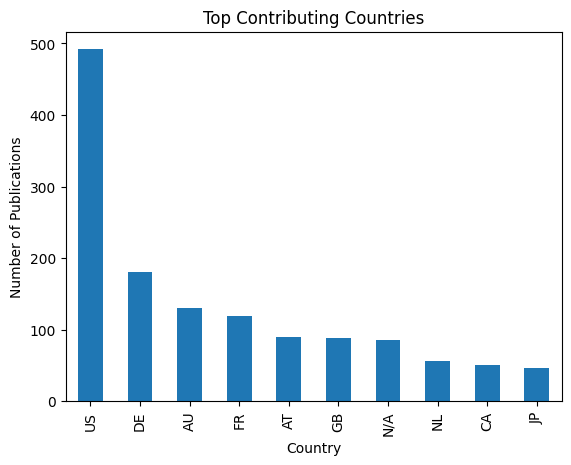

In [11]:
#countries
top_countries = df['Countries'].str.split(', ').explode().value_counts().head(10)
top_countries.plot(kind='bar')
plt.title("Top Contributing Countries")
plt.xlabel("Country")
plt.ylabel("Number of Publications")
plt.show()


In [12]:
#make the pairs
country_pairs = []
for countries in df['Countries']:
    country_list = list(set(countries.split(', ')))
    country_pairs += list(combinations(country_list, 2))

pair_counts = Counter(country_pairs)
top_pairs = dict(sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)[:10])
print("Top Country Collaborations:\n", top_pairs)


Top Country Collaborations:
 {('US', 'DE'): 15, ('AU', 'GB'): 11, ('US', 'AU'): 9, ('US', 'GB'): 9, ('DE', 'GB'): 7, ('JP', 'US'): 7, ('GB', 'CA'): 7, ('US', 'N/A'): 6, ('US', 'AT'): 6, ('FR', 'DE'): 6}


In [14]:
#citations
df.groupby('Authors')['Citations'].sum().sort_values(ascending=False).head(10)


Authors
Michael A. Nielsen, Isaac L. Chuang, Lov K. Grover                                                                                           24336
Michael A. Nielsen, Isaac L. Chuang                                                                                                           9413
Marlan O. Scully, M. Suhail Zubairy                                                                                                           5863
H. J. Kimble                                                                                                                                  5459
E. Knill, Raymond Laflamme, G. J. Milburn                                                                                                     5375
R. Loudon                                                                                                                                     5067
Robert Raussendorf, Hans J. Briegel                                                                           

In [15]:
#double check for empty data. does this get rid of the N/As? 
if df.empty:
    print("No data to analyze.")
else:
    print(df.head())


                                               Title  \
0  <i>Quantum Computation and Quantum Information...   
1        Quantum Computation and Quantum Information   
2                                     Quantum Optics   
3  A scheme for efficient quantum computation wit...   
4                               The quantum internet   

                                             Authors  \
0  Michael A. Nielsen, Isaac L. Chuang, Lov K. Gr...   
1                Michael A. Nielsen, Isaac L. Chuang   
2                Marlan O. Scully, M. Suhail Zubairy   
3          E. Knill, Raymond Laflamme, G. J. Milburn   
4                                       H. J. Kimble   

                                        Institutions       Countries  \
0                                      N/A, N/A, N/A   N/A, N/A, N/A   
1         N/A, Massachusetts Institute of Technology         N/A, US   
2        Mitchell Institute, Quaid-i-Azam University          US, PK   
3  Los Alamos National Laboratory, Los

In [16]:
#start with nx
G = nx.Graph()

#create edges
for index, row in df.iterrows():
    authors = row['Authors'].split(', ')
    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):
            if G.has_edge(authors[i], authors[j]):
                G[authors[i]][authors[j]]['weight'] += 1  #maybe do a weight for repeated collaborations
            else:
                G.add_edge(authors[i], authors[j], weight=1)


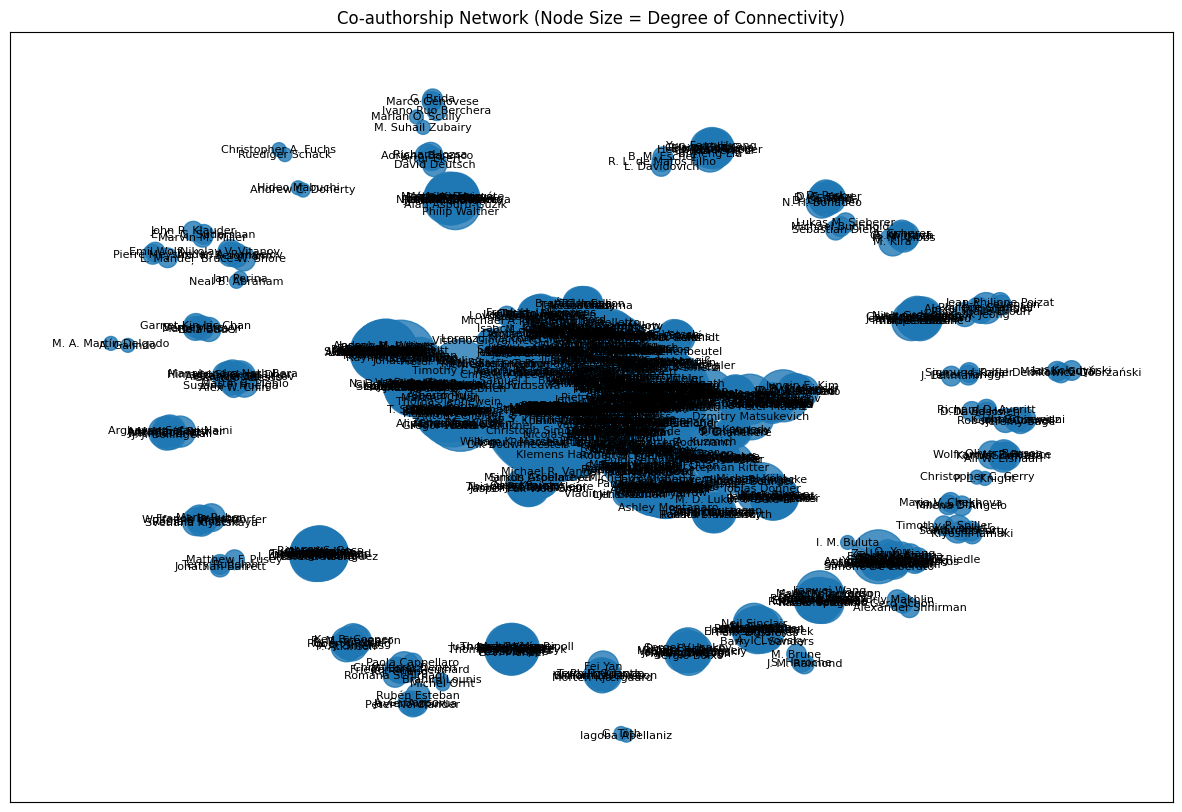

In [17]:
degree = dict(G.degree())
node_size = [v * 100 for v in degree.values()]  #nodes are too small need them larger

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, seed=42)

#draw nodes
nx.draw_networkx_nodes(G, pos, node_size=node_size, alpha=0.8)

#draw edges
nx.draw_networkx_edges(G, pos, alpha=0.4)

#draw labels with reduced overlap
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Co-authorship Network (Node Size = Degree of Connectivity)")
plt.show()


Number of Nodes (Authors): 874
Number of Edges (Collaborations): 8421
Top 10 Authors by Degree Centrality:
B. Barr: 0.11
V. B. Braginsky: 0.11
J. Abadie: 0.11
B. P. Abbott: 0.11
R. Abbott: 0.11
T. D. Abbott: 0.11
M. R. Abernathy: 0.11
C. Adams: 0.11
R. X. Adhikari: 0.11
C. Affeldt: 0.11
Number of Communities Detected: 56


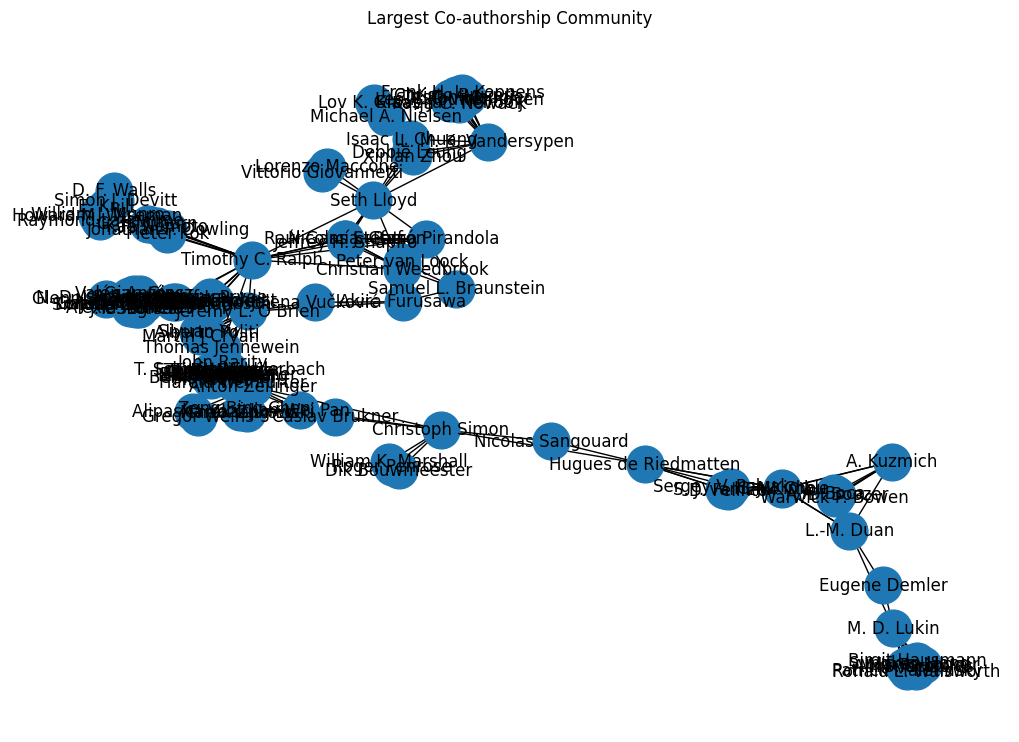

In [18]:
#print out the basic info/stats
print("Number of Nodes (Authors):", G.number_of_nodes())
print("Number of Edges (Collaborations):", G.number_of_edges())

#top 10 most connected authors
degree_centrality = nx.degree_centrality(G)
top_authors = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Authors by Degree Centrality:")
for author, score in top_authors:
    print(f"{author}: {score:.2f}")

#community Detection? (is this how it works?)
from networkx.algorithms import community
communities = community.greedy_modularity_communities(G)
print(f"Number of Communities Detected: {len(communities)}")

#visualize largest community
largest_community = max(communities, key=len)
H = G.subgraph(largest_community)

plt.figure(figsize=(10, 7))
nx.draw(H, pos, with_labels=True, node_size=700)
plt.title("Largest Co-authorship Community")
plt.show()


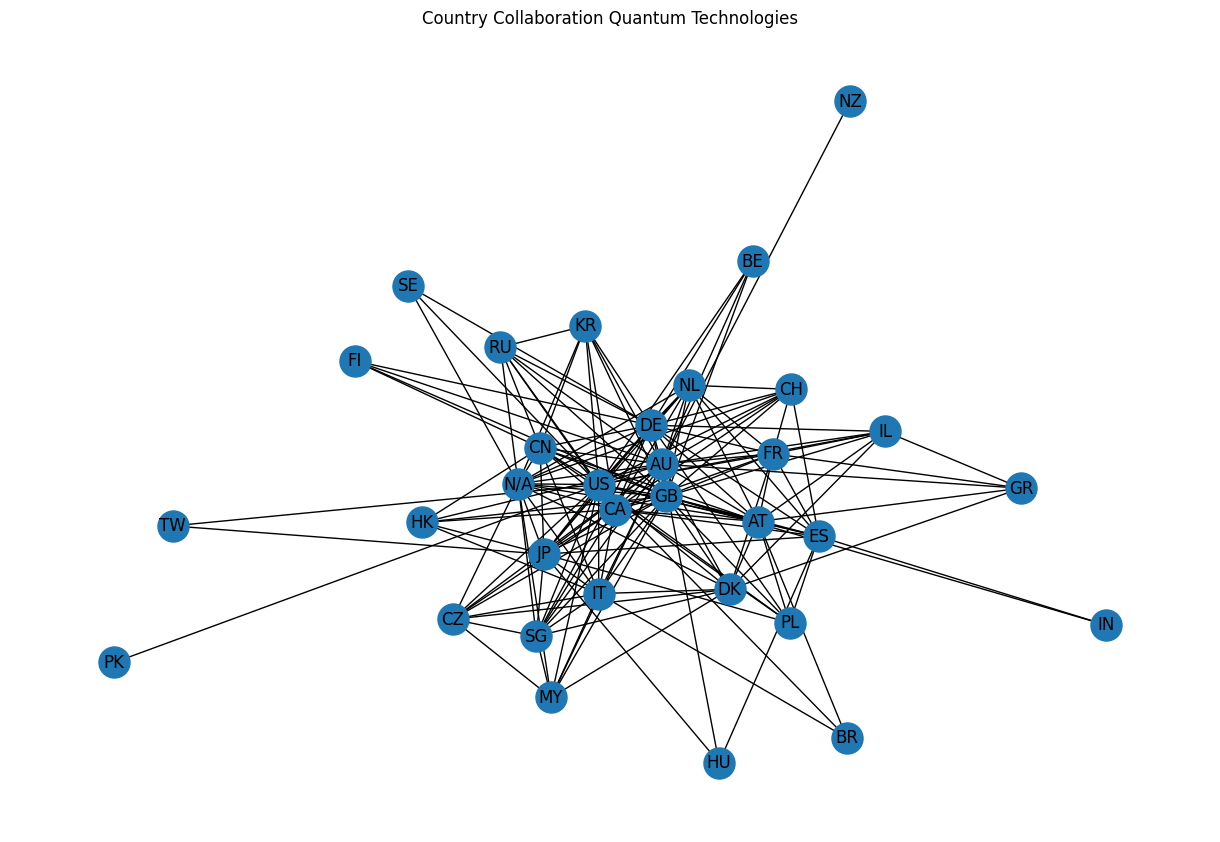

In [20]:
from itertools import combinations
from collections import Counter

country_edges = []

for index, row in df.iterrows():
    countries = list(set(row['Countries'].split(', ')))
    country_edges += list(combinations(countries, 2))

#co-authorships by country
country_pairs = Counter(country_edges)

#attempt at country-level graph
G_country = nx.Graph()

for pair, weight in country_pairs.items():
    G_country.add_edge(pair[0], pair[1], weight=weight)

#plot, but unsure how this will look
plt.figure(figsize=(12, 8))
pos_country = nx.spring_layout(G_country, seed=42)
nx.draw(G_country, pos_country, with_labels=True, node_size=500)
plt.title("Country Collaboration Quantum Technologies")
plt.show()


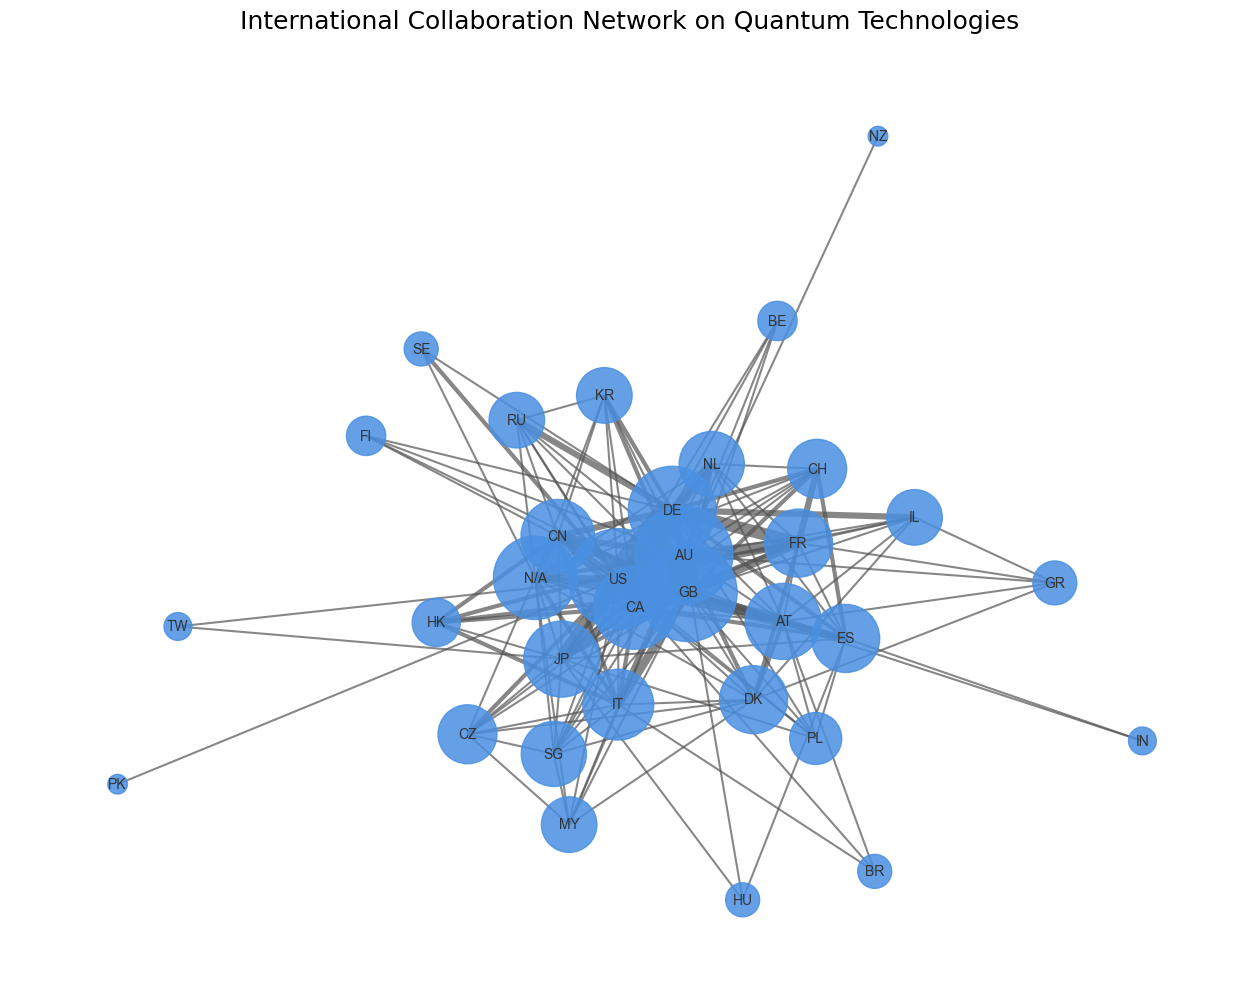

In [21]:
#copy from above
country_edges = []
for index, row in df.iterrows():
    countries = list(set(row['Countries'].split(', ')))
    country_edges += list(combinations(countries, 2))

#copy from above
country_pairs = Counter(country_edges)

#copy from above
G_country = nx.Graph()
for pair, weight in country_pairs.items():
    G_country.add_edge(pair[0], pair[1], weight=weight)

#this and parts below is where I'm caonfused
plt.figure(figsize=(16, 12))
pos_country = nx.spring_layout(G_country, seed=42)

#scale the nodes to make them noticable
node_size = [v * 200 for v in dict(G_country.degree()).values()]

#factor in the weights
edge_width = [d['weight'] * 1.5 for (u, v, d) in G_country.edges(data=True)]

#draw edges. same as before
nx.draw_networkx_edges(G_country, pos_country, width=edge_width, alpha=0.7, edge_color="#555")

#draw nodes. same as before
nx.draw_networkx_nodes(G_country, pos_country, node_size=node_size, node_color="#4a90e2", alpha=0.85)

#draw labels. last attempt didn't work right. remember to play with font size
nx.draw_networkx_labels(G_country, pos_country, font_size=10, font_family="Arial", font_color="#333")

#plt title and display
plt.title("International Collaboration Network on Quantum Technologies", fontsize=18, pad=20)
plt.axis('off')  # Hide axes
plt.show()
